In [1]:
from pyofss import Domain, System, Gaussian, Fibre, OpenclFibre
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda, multi_plot, single_plot, labels
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import pylab as plt
plt.switch_backend('agg')
from scipy.signal import find_peaks
import time
%matplotlib inline


In [2]:
lamb0 = 1028
peak_power = 600   
peak_width = 2    
peak_C = 0.
total_steps = int(30001/40)
betta_2 = 20  
gamma_active = 5.1  
La_1 = (7/40)*1e-3

Pp_0 = 10               # Ws
N = 4.8
Rr = 80*1e-6            # THz
Tr = 1/Rr    

domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(lamb0))
gaussian = Gaussian(name="initial_pulse", peak_power=peak_power,
                    width=peak_width, C=peak_C, using_fwhm=True)

In [3]:
sys = System(domain)
sys.add(gaussian)
sys.add(Fibre(length=La_1, total_steps=total_steps, traces=total_steps, method="ss_symmetric",
            raman_scattering=True, beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            use_Yb_model=True, N=N, Pp_0=Pp_0, Rr=Rr))

start = time.time()
sys.run()
stop = time.time()
NO_CL_OUT = sys.field

print("Run time without cl is {}".format(stop-start))

use two level Yb gain model
Using general expression for nonlinearity
Caching linear factor


c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:282: RuntimeWarning: invalid value encountered in true_divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:216: RuntimeWarning: divide by zero encountered in true_divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)


Run time without cl is 6.452683210372925


c:\Users\User1\Programs\examples\pyofss\modules\storage.py:225: UserWarning: Nothing will be saved - base fibre directory is not stated!
  warnings.warn("Nothing will be saved - base fibre directory is not stated!")


In [4]:
sys.df_results

,max_value,energy,duration,spec_width,peaks
z [mm],,,,,
0.233333,601.082064,1.279666,2.000007,0.220641,[8192]
0.466667,602.165428,1.281974,2.000009,0.220640,[8192]
0.700000,603.250093,1.284285,2.000012,0.220640,[8192]
0.933333,604.336059,1.286599,2.000014,0.220639,[8192]
1.166667,605.423325,1.288915,2.000017,0.220639,[8192]
...,...,...,...,...,...
174.066667,1735.755021,3.705558,2.006834,0.229425,[8192]
174.300000,1737.647991,3.709626,2.006853,0.229467,[8192]
174.533333,1739.541726,3.713695,2.006872,0.229509,[8192]


In [6]:
sys.init_df("temp")
print(sys.df_type_dict["temp"].shape)
sys.df_type_dict["temp"]

(750, 16384)


,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
z [mm],,,,,,,,,,,,,,,,,,,,,
0.233333,1.301608e-23,1.299046e-23,1.300328e-23,1.297769e-23,1.299051e-23,1.299052e-23,1.297775e-23,1.293941e-23,1.297780e-23,1.297782e-23,...,1.290107e-23,1.293941e-23,1.295212e-23,1.295211e-23,1.291378e-23,1.297767e-23,1.297768e-23,1.293929e-23,1.299046e-23,1.299047e-23
0.466667,5.214128e-23,5.203873e-23,5.201316e-23,5.201322e-23,5.201332e-23,5.196213e-23,5.198791e-23,5.178326e-23,5.191128e-23,5.196260e-23,...,5.173182e-23,5.180866e-23,5.188520e-23,5.183404e-23,5.178283e-23,5.196186e-23,5.206435e-23,5.188504e-23,5.203873e-23,5.191069e-23
0.700000,1.173372e-22,1.171449e-22,1.171835e-22,1.172606e-22,1.172223e-22,1.171071e-22,1.171075e-22,1.169155e-22,1.169927e-22,1.170698e-22,...,1.165308e-22,1.167996e-22,1.168760e-22,1.166840e-22,1.167607e-22,1.169526e-22,1.171832e-22,1.169141e-22,1.171833e-22,1.170296e-22
0.933333,2.089246e-22,2.087193e-22,2.086684e-22,2.088740e-22,2.087205e-22,2.085155e-22,2.084650e-22,2.081577e-22,2.082607e-22,2.085179e-22,...,2.073872e-22,2.080530e-22,2.080014e-22,2.078476e-22,2.080524e-22,2.083086e-22,2.087190e-22,2.083599e-22,2.084628e-22,2.084629e-22
1.166667,3.269427e-22,3.266216e-22,3.266223e-22,3.267513e-22,3.264952e-22,3.261106e-22,3.261762e-22,3.257278e-22,3.257926e-22,3.261146e-22,...,3.245700e-22,3.254668e-22,3.254665e-22,3.250819e-22,3.257227e-22,3.257226e-22,3.262999e-22,3.259792e-22,3.261081e-22,3.261724e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174.066667,1.388490e-17,1.388807e-17,1.388925e-17,1.388687e-17,1.388203e-17,1.387483e-17,1.386587e-17,1.385461e-17,1.384328e-17,1.382789e-17,...,1.383419e-17,1.384107e-17,1.384590e-17,1.385048e-17,1.385517e-17,1.386066e-17,1.386599e-17,1.387211e-17,1.387704e-17,1.388204e-17
174.300000,1.392789e-17,1.393108e-17,1.393224e-17,1.392987e-17,1.392497e-17,1.391775e-17,1.390873e-17,1.389751e-17,1.388606e-17,1.387067e-17,...,1.387704e-17,1.388396e-17,1.388876e-17,1.389339e-17,1.389811e-17,1.390365e-17,1.390897e-17,1.391508e-17,1.392005e-17,1.392502e-17
174.533333,1.397095e-17,1.397411e-17,1.397529e-17,1.397296e-17,1.396795e-17,1.396074e-17,1.395166e-17,1.394046e-17,1.392890e-17,1.391352e-17,...,1.392001e-17,1.392692e-17,1.393170e-17,1.393635e-17,1.394110e-17,1.394667e-17,1.395199e-17,1.395815e-17,1.396306e-17,1.396803e-17


In [7]:
sys.init_df("complex")
print(sys.df_type_dict["complex"].shape)
sys.df_type_dict["complex"]

(750, 16384)


,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
z [mm],,,,,,,,,,,,,,,,,,,,,
0.233333,3.607781e-12+1.052977e-15j,3.604228e-12+1.955033e-15j,3.606004e-12+3.819861e-15j,3.602452e-12+5.344683e-15j,3.604228e-12+6.897261e-15j,3.604228e-12+7.643192e-15j,3.602452e-12+9.508019e-15j,3.597123e-12+1.070498e-14j,3.602452e-12+1.185683e-14j,3.602452e-12+1.269818e-14j,...,3.591794e-12-9.402201e-15j,3.597123e-12-1.085243e-14j,3.598899e-12-7.100223e-15j,3.598899e-12-5.604892e-15j,3.593570e-12-5.991735e-15j,3.602452e-12-3.623837e-15j,3.602452e-12-4.813858e-15j,3.597123e-12-1.507475e-15j,3.604228e-12+1.106754e-15j,3.604228e-12+3.406997e-15j
0.466667,7.220891e-12+4.440892e-15j,7.213785e-12+5.606626e-15j,7.212009e-12+9.658940e-15j,7.212009e-12+1.240674e-14j,7.212009e-12+1.564027e-14j,7.208456e-12+1.701070e-14j,7.210232e-12+2.137179e-14j,7.196022e-12+2.306835e-14j,7.204903e-12+2.547962e-14j,7.208456e-12+2.756823e-14j,...,7.192469e-12-1.455780e-14j,7.197798e-12-1.912359e-14j,7.203127e-12-1.272246e-14j,7.199574e-12-1.295838e-14j,7.196022e-12-1.025569e-14j,7.208456e-12-4.687223e-15j,7.215561e-12-5.044576e-15j,7.203127e-12+7.563394e-16j,7.213785e-12+6.064593e-15j,7.204903e-12+7.462780e-15j
0.700000,1.083222e-11+9.891393e-15j,1.082334e-11+1.107794e-14j,1.082512e-11+1.723621e-14j,1.082867e-11+2.117403e-14j,1.082689e-11+2.604514e-14j,1.082157e-11+2.801231e-14j,1.082157e-11+3.492345e-14j,1.081268e-11+3.707104e-14j,1.081624e-11+4.089437e-14j,1.081979e-11+4.447831e-14j,...,1.079492e-11-2.104567e-14j,1.080736e-11-2.510492e-14j,1.081091e-11-1.717723e-14j,1.080203e-11-1.581721e-14j,1.080558e-11-1.266695e-14j,1.081446e-11-5.082740e-15j,1.082512e-11-5.089679e-15j,1.081268e-11+3.115563e-15j,1.082512e-11+1.173367e-14j,1.081801e-11+1.401657e-14j
0.933333,1.445422e-11+1.732642e-14j,1.444711e-11+1.887379e-14j,1.444533e-11+2.671474e-14j,1.445244e-11+3.238382e-14j,1.444711e-11+3.843453e-14j,1.444000e-11+4.157785e-14j,1.443823e-11+5.061923e-14j,1.442757e-11+5.399847e-14j,1.443112e-11+5.814099e-14j,1.444000e-11+6.430967e-14j,...,1.440092e-11-2.415429e-14j,1.442402e-11-2.653433e-14j,1.442224e-11-1.814521e-14j,1.441691e-11-1.514067e-14j,1.442402e-11-1.219858e-14j,1.443290e-11-2.553513e-15j,1.444711e-11-1.186551e-15j,1.443468e-11+5.648260e-15j,1.443823e-11+1.849909e-14j,1.443823e-11+2.028933e-14j
1.166667,1.808154e-11+2.658984e-14j,1.807265e-11+2.836620e-14j,1.807265e-11+3.819861e-14j,1.807621e-11+4.539424e-14j,1.806910e-11+5.279804e-14j,1.805844e-11+5.668382e-14j,1.806022e-11+6.789014e-14j,1.804779e-11+7.205347e-14j,1.804956e-11+7.682743e-14j,1.805844e-11+8.505002e-14j,...,1.801581e-11-2.291223e-14j,1.804068e-11-2.627065e-14j,1.804068e-11-2.024769e-14j,1.803002e-11-1.562639e-14j,1.804779e-11-1.065120e-14j,1.804779e-11+1.346145e-15j,1.806377e-11+6.980527e-15j,1.805489e-11+1.054018e-14j,1.805844e-11+2.731843e-14j,1.806022e-11+2.951805e-14j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174.066667,3.580888e-09+1.030600e-09j,3.580737e-09+1.032660e-09j,3.580436e-09+1.034280e-09j,3.579720e-09+1.035605e-09j,3.578723e-09+1.036710e-09j,3.577490e-09+1.037495e-09j,3.576069e-09+1.038075e-09j,3.574392e-09+1.038426e-09j,3.572643e-09+1.038991e-09j,3.570396e-09+1.039311e-09j,...,3.580556e-09+1.006882e-09j,3.580787e-09+1.009472e-09j,3.580748e-09+1.011998e-09j,3.580739e-09+1.014289e-09j,3.580750e-09+1.016563e-09j,3.580881e-09+1.018797e-09j,3.580981e-09+1.021061e-09j,3.581166e-09+1.023409e-09j,3.581160e-09+1.025832e-09j,3.581160e-09+1.028265e-09j
174.300000,3.585923e-09+1.033950e-09j,3.585770e-09+1.036017e-09j,3.585463e-09+1.037641e-09j,3.584748e-09+1.038966e-09j,3.583743e-09+1.040075e-09j,3.582510e-09+1.040853e-09j,3.581079e-09+1.041442e-09j,3.579412e-09+1.041787e-09j,3.577645e-09+1.042359e-09j,3.575405e-09+1.042665e-09j,...,3.585612e-09+1.010161e-09j,3.585843e-09+1.012765e-09j,3.585797e-09+1.015295e-09j,3.585791e-09+1.017590e-09j,3.585800e-09+1.019878e-09j,3.585933e-09+1.022123e-09j,3.586027e-09+1.024389e-09j,3.586

In [8]:
sys1 = System(domain)
sys1.add(gaussian)
sys1.add(OpenclFibre(length=La_1, total_steps=total_steps,
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            use_Yb_model=True, N=N, Pp_0=Pp_0, Rr=Rr, fast_math=True,
            dorf='double', traces=100, downsampling=500))
start = time.time()
sys1.run()
stop = time.time()
CL_OUT = sys1.field

print("Run time with cl is {}".format(stop-start))

Using compiler optimisations suitable for Nvidia GPUs
use two level Yb gain model
Using general expression for nonlinearity
Caching linear factor


c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:216: RuntimeWarning: divide by zero encountered in true_divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)
c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:282: RuntimeWarning: invalid value encountered in true_divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)


Global memory size: 2147221504
Global memory size: 2147221504
Run time with cl is 4.795853853225708


In [4]:
sys1.init_df("temp")
sys1.df_type_dict["temp"]

0             1             2    \
cycle  fibre     z [mm]                                                 
cycle0 ocl_fibre 0.233333    1.301608e-23  1.248800e-23  1.122603e-23   
                 1.866667    8.397114e-22  8.058817e-22  7.241072e-22   
                 3.500000    2.979835e-21  2.859986e-21  2.570190e-21   
                 5.133333    6.469466e-21  6.207689e-21  5.578166e-21   
                 6.766667    1.134512e-20  1.088607e-20  9.780515e-21   
...                                   ...           ...           ...   
                 168.466667  1.286525e-17  1.220201e-17  1.074745e-17   
                 170.100000  1.315571e-17  1.247508e-17  1.098583e-17   
                 171.733333  1.344957e-17  1.275093e-17  1.122664e-17   
                 173.366667  1.374655e-17  1.302956e-17  1.146997e-17   
                 175.000000  1.404653e-17  1.331086e-17  1.171566e-17   

                                      3             4             5    \
cycle  fibre     z [mm]                                                 
cycle0 ocl_fibre 0.233333    9.934194e-24  9.259594e-24  9.527617e-24   
                 1.866667    6.417356e-22  5.985017e-22  6.155434e-22   
                 3.500000    2.276181e-21  2.124160e-21  2.184896e-21   
                 5.133333    4.939989e-21  4.610237e-21  4.745084e-21   
                 6.766667    8.658202e-21  8.082778e-21  8.323301e-21   
...                                   ...           ...           ...   
                 168.466667  9.577100e-18  9.398817e-18  1.009539e-17   
                 170.100000  9.793545e-18  9.620240e-18  1.033723e-17   
                 171.733333  1.001249e-17  9.844519e-18  1.058246e-17   
                 173.366667  1.023401e-17  1.007177e-17  1.083114e-17   
                 175.000000  1.045803e-17  1.030207e-17  1.108320e-17   

                                      6             7             8    \
cycle  fibre     z [mm]                                                 
cycle0 ocl_fibre 0.233333    1.062769e-23  1.209501e-23  1.317419e-23   
                 1.866667    6.865602e-22  7.809772e-22  8.505578e-22   
                 3.500000    2.437100e-21  2.771653e-21  3.017833e-21   
                 5.133333    5.293058e-21  6.018330e-21  6.551364e-21   
                 6.766667    9.285637e-21  1.055506e-20  1.148754e-20   
...                                   ...           ...           ...   
                 168.466667  1.114860e-17  1.219023e-17  1.292990e-17   
                 170.100000  1.141049e-17  1.246820e-17  1.322032e-17   
                 171.733333  1.167565e-17  1.274934e-17  1.351397e-17   
                 173.366667  1.194414e-17  1.303359e-17  1.381072e-17   
                 175.000000  1.221590e-17  1.332095e-17  1.411049e-17   

                                      9    ...           490           491  \
cycle  fibre     z [mm]                    ...                               
cycle0 ocl_fibre 0.233333    1.326701e-23  ...  1.229792e-23  1.324675e-23   
                 1.866667    8.567269e-22  ...  7.940898e-22  8.557209e-22   
                 3.500000    3.040037e-21  ...  2.818175e-21  3.036422e-21   
                 5.133333    6.599455e-21  ...  6.119196e-21  6.591995e-21   
                 6.766667    1.157017e-20  ...  1.073097e-20  1.156080e-20   
...                                   ...  ...           ...           ...   
                 168.466667  1.293798e-17  ...  1.242542e-17  1.330509e-17   
                 170.100000  1.322773e-17  ...  1.271021e-17  1.360826e-17   
                 171.733333  1.352055e-17  ...  1.299836e-17  1.391488e-17   
                 173.366667  1.381639e-17  ...  1.328984e-17  1.422499e-17   
                 175.000000  1.411516e-17  ...  1.358461e-17  1.453849e-17   

                                      492           493           494  \
cycle  fibre     z [mm]                                                 
cycle0 ocl_fibre 0.233333  

In [9]:
sys1.df_results

max_value              energy duration  \
cycle  fibre     z [mm]                                                        
cycle0 ocl_fibre 0.233333      601.082063909846  1.2796658028064076      NaN   
                 0.466667     602.1654283029754  1.2819739623828692      NaN   
                 0.700000     603.2500931403555   1.284284902013399      NaN   
                 0.933333     604.3360583798733   1.286598621658133      NaN   
                 1.166667     605.4233239763362  1.2889151212708092      NaN   
...                                         ...                 ...      ...   
                 174.066667  1735.6936942051643   3.705552600574046      NaN   
                 174.300000  1737.5863959722924    3.70962001793867      NaN   
                 174.533333  1739.4798611708957   3.713689168603013      NaN   
                 174.766667  1741.3740888520642   3.717760050771318      NaN   
                 175.000000  1743.2690780671328  3.7218326626486267      NaN   

                            spec_width peaks  
cycle  fibre     z [mm]                       
cycle0 ocl_fibre 0.233333          NaN   NaN  
                 0.466667          NaN   NaN  
                 0.700000          NaN   NaN  
                 0.933333          NaN   NaN  
                 1.166667          NaN   NaN  
...                                ...   ...  
                 174.066667        NaN   NaN  
                 174.300000        NaN   NaN  
                 174.533333        NaN   NaN  
                 174.766667        NaN   NaN  
                 175.000000        NaN   NaN  

[750 rows x 5 columns]

In [12]:
sys1.save_df_to_csv("C:/Users/User1/Programs/examples/results/", df_type="temp")

c:\Users\User1\Programs\examples\pyofss\modules\storage.py:106: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


In [13]:
sys1.save_result_df_to_scv("C:/Users/User1/Programs/examples/results/")


Generating single_plot...

Generating single_plot...


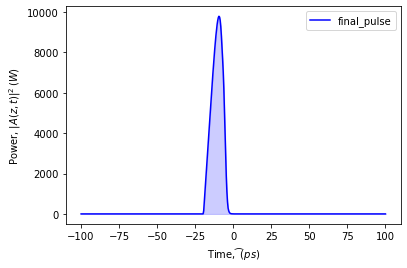

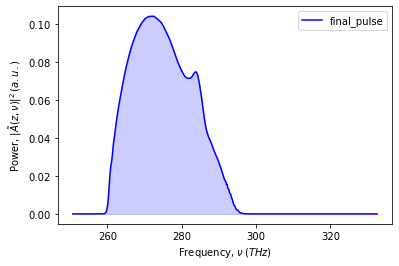

In [11]:
from scipy.interpolate import interp1d
import os

# Create a linear interpolation function
f_t = interp1d(np.arange(len(domain.t)), domain.t)

# Interpolate the function values at 100 equally spaced points
interpolated_t = f_t(np.linspace(0, len(domain.t) - 1, 500))

f_nu = interp1d(np.arange(len(domain.nu)), domain.nu)

# Interpolate the function values at 100 equally spaced points
interpolated_nu = f_nu(np.linspace(0, len(domain.nu) - 1, 500))


single_plot(interpolated_t, sys1.df_temp.iloc[-1], labels["t"], labels["P_t"], "final_pulse")
plt.savefig(os.path.join("", 'final_pulse_t'))
single_plot(interpolated_nu, sys1.df_spec.iloc[-1], labels["nu"], labels["P_nu"], "final_pulse")
plt.savefig(os.path.join("", 'final_pulse_nu'))

In [12]:
lines = []

def get_peaks(P):
    peaks, _ = find_peaks(P, height=0, prominence=(np.amax(P)/10))
    return peaks


output_peak_power = sys1.df_results.iloc[-1]["max_value"]
output_energy = sys1.df_results.iloc[-1]["energy"]
output_peaks = get_peaks(temporal_power(sys1.field))
lines.append(f"output_peaks: {output_peaks}")
lines.append(f"num of peaks: {len(output_peaks)}")
lines.append(f"output_peak_power: {output_peak_power}")
lines.append(f"output_energy: {output_energy} nJ")
lines.append(f"L_NL {sys1.modules[1].L_NL*1e3} m")
lines.append(f"L_D {sys1.modules[1].L_D*1e3} m")

with open(os.path.join("C:/Users/User1/Programs/examples", "output_info.txt"), 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [ ]:
multi_plot(sys1.domain.t, [temporal_power(sys.field), temporal_power(sys1.field)], ["cpu", "gpu"], labels["t"], labels["P_t"],
            x_range=(-20.0, 40.0), use_fill=False)
plt.savefig('raman_cl_compare')
df_results = sys.df_results  
df_results1 = sys1.df_results
energy_arr = df_results['energy'].values
energy_arr1 = df_results1['energy'].values
multi_plot(df_results.index.get_level_values("z [mm]").values, [energy_arr, energy_arr1], ["cpu", "gpu"], labels["z"], "E_t", use_fill=False)
plt.savefig('raman_cl_compare_energy')

NO_CL_POWER = temporal_power(NO_CL_OUT)
CL_POWER = temporal_power(CL_OUT)
DELTA_POWER = NO_CL_POWER - CL_POWER

MEAN_RELATIVE_ERROR = np.mean(np.abs(DELTA_POWER))
MEAN_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

MAX_RELATIVE_ERROR = np.max(np.abs(DELTA_POWER))
MAX_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

print("Mean relative error: %e" % MEAN_RELATIVE_ERROR)
print("Max relative error: %e" % MAX_RELATIVE_ERROR)

NameError: name 'sys' is not defined

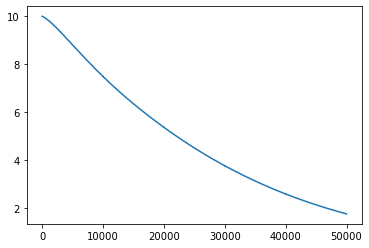

In [18]:
plt.plot(sys1.modules[1].amplifier.Pp_list)
plt.plot(sys.modules[1].amplifier.Pp_list)

In [6]:
plt.plot(sys1.modules[1].amplifier.gs_list[4000])
plt.plot(sys.modules[1].amplifier.gs_list[4000])

IndexError: list index out of range

NameError: name 'sys' is not defined

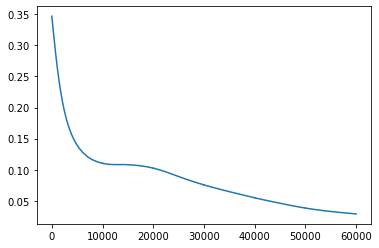

In [4]:
plt.plot(sys1.modules[1].amplifier.inversion_factor_list)
plt.plot(sys.modules[1].amplifier.inversion_factor_list)

NameError: name 'sys' is not defined

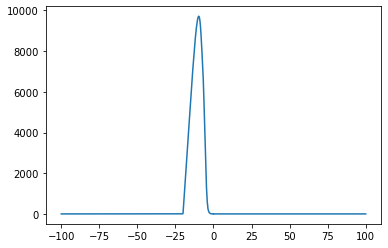

In [4]:
%matplotlib inline
plt.plot(domain.t, temporal_power(sys1.field))
plt.plot(domain.t, temporal_power(sys.field))
plt.show()

In [20]:
sys.df_results

In [22]:
print(sys1.df_results)

None


In [6]:
multi_plot(sys1.domain.t, [temporal_power(sys.field), temporal_power(sys1.field)], ["cpu", "gpu"], labels["t"], labels["P_t"],
            x_range=(-20.0, 40.0), use_fill=False)
plt.savefig('raman_cl_compare')
df_results = sys.df_results  
df_results1 = sys1.df_results
energy_arr = df_results['energy'].values
energy_arr1 = df_results1['energy'].values
multi_plot(df_results.index.get_level_values("z [mm]").values, [energy_arr, energy_arr1], ["cpu", "gpu"], labels["z"], "E_t", use_fill=False)
plt.savefig('raman_cl_compare_energy')

NO_CL_POWER = temporal_power(NO_CL_OUT)
CL_POWER = temporal_power(CL_OUT)
DELTA_POWER = NO_CL_POWER - CL_POWER

MEAN_RELATIVE_ERROR = np.mean(np.abs(DELTA_POWER))
MEAN_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

MAX_RELATIVE_ERROR = np.max(np.abs(DELTA_POWER))
MAX_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

print("Mean relative error: %e" % MEAN_RELATIVE_ERROR)
print("Max relative error: %e" % MAX_RELATIVE_ERROR)

NameError: name 'sys' is not defined

In [ ]:
fib = Fibre(length=La_1, total_steps=total_steps, traces=total_steps, 
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True)

sys = System(domain)
sys.add(gaussian)
sys.add(fib)

start = time.time()
sys.run()
stop = time.time()
NO_CL_OUT = sys.field

print("Run time without cl is {}".format(stop-start))

Using general expression for nonlinearity
Caching linear factor
Run time without cl is 56.599210023880005


In [ ]:
sys1 = System(domain)
sys1.add(gaussian)
sys1.add(OpenclFibre(length=La_1, total_steps=total_steps,
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            dorf='double'))
start = time.time()
sys1.run()
stop = time.time()
CL_OUT = sys1.field

print("Run time with cl is {}".format(stop-start))

Using general expression for nonlinearity
Caching linear factor
Global memory size: 2147221504
Global memory size: 2147221504
Run time with cl is 25.438766479492188


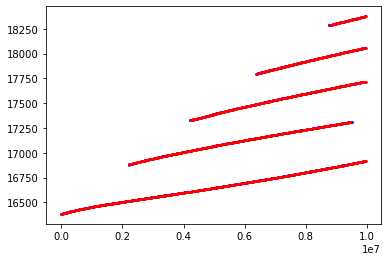

In [ ]:
%matplotlib inline

for i in range(len(sys1.df_results['peaks'].values)):
    peaks_arr = np.array(sys1.df_results['peaks'].values[i])
    z_arr = np.full(peaks_arr.shape, sys1.df_results.index.get_level_values("z [mm]").values[i])
    plt.scatter(z_arr, peaks_arr, s=3, c="b")


for i in range(len(sys.df_results['peaks'].values)):
    peaks_arr = np.array(sys.df_results['peaks'].values[i])
    z_arr = np.full(peaks_arr.shape, sys.df_results.index.get_level_values("z [mm]").values[i])
    plt.scatter(z_arr, peaks_arr, s=3, c="r")
plt.show()

In [6]:
import pandas as pd
true_temp = pd.read_csv("time_out_1.dat", sep='\t', names=['X', 'temp_power', 'Y'], header=None)

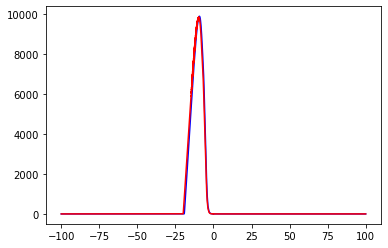

In [7]:
plt.plot(domain.t, temporal_power(sys1.field), c="b")
plt.plot(domain.t, true_temp["temp_power"], c="r")

In [4]:
np.amax(temporal_power(sys1.field))/peak_power

98.75290886524388

In [5]:
plt.plot(domain.t, true_temp["temp_power"], c="r")

NameError: name 'true_temp' is not defined